In [99]:
%matplotlib inline

import wikipedia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import copy
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

from IPython.display import Image

import nltk
from nltk.stem.snowball import SnowballStemmer

In [2]:
stemmer = SnowballStemmer('english')

# tokenize words in docs
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [3]:
#because my version of pandas is different than the version that descriptions.pkl was created with
with open("descriptions.txt") as desc:
    descriptions = desc.readlines()
titles = []
descs = []
tempDesc = ''
for description in descriptions:
    if description[0].isnumeric():
        titles.append(description[4:-1])
    elif description == '\n':
        descs.append(tempDesc)
        tempDesc = ''
    else:
        tempDesc += description[:-1]
descs.append(tempDesc)

In [80]:
titles[108:]

array(['War Horse', 'Cheikh Lo', 'Dave Holland', 'Gabriel Kahane',
       'Suzhou Kun Troupe', 'Ensemble Basiani',
       "Jason Moran's Fats Waller Dance Party", 'Dan Zanes and Friend',
       'Max Raabe', 'Last of the Haussmans', 'Timon of Athens',
       'Traveling Light', 'Colin Stetson', 'Fred Hersch Trio',
       'One Night in Bamako', 'Alfredo Rodriguez', 'Beijing Guitar Duo',
       'One Man, Two Gu', 'Frankenstein', 'The Kitchen',
       'The Comedy of Errors', 'Mavericks All Access', 'People',
       'This House', 'The Curious Incident of the Dog in the Night-Time',
       'Coriolanus', 'Steve Lehman Octet', 'Asif Ali Khan', 'DC: Hubbard',
       'FAM -Aspen Santa Fe', 'James Blake', "Breakin' Curfew", 'Fela!',
       'DC: Ballet Preljocaj', 'Diego El Cigala', 'Usher Party'], dtype=object)

In [4]:
titles = pd.read_csv("full_performance_names.csv",header=None)
titles = np.ravel(titles[[1]])

In [5]:
# Extract bigram matrix
tokenizedDescs = []
temp = [tokenize_and_stem(d) for d in descs]
for desc in temp:
    sb = ""
    for s in desc:
        sb += s
        sb += " "
    tokenizedDescs.append(sb)

In [6]:
vect = CountVectorizer(ngram_range=(1, 1), stop_words = ENGLISH_STOP_WORDS, min_df = 5)
X = vect.fit_transform(tokenizedDescs)

print(X.shape)

(144, 478)


In [7]:
#LDA
lda = LatentDirichletAllocation(n_topics=5, max_iter=10)
y = lda.fit_transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

print_top_words(lda, vect.get_feature_names(), 20)

Topic #0:
jazz perform lincoln cultur center band orchestra music live world ensembl play program tradit audienc rich rang like new interpret
Topic #1:
music perform um new concert compos time work danc american year voic seat featur creat york ticket arbor ann best
Topic #2:
opera artist stage renegad quartet interpret fresh year classic veri experi contemporari human david intens richard man histori concert describ
Topic #3:
nation theatr london theater broadcast michigan present play partnership high compani definit new time ballet director work dancer win year
Topic #4:
perform danc centuri program return work age william art thing new ballet includ choreographi music compani night choreograph york make


In [60]:
wikipediaDescs = copy.copy(descs)
noPage = ["AnDa Union","FAM -Aspen Santa Fe","People"]
fixedPages = {     'The Silk Road Ensemble': 'Joseph Gramley',     
 'Royal Shakespeare Company Live in HD: Richard II': 'Richard the Second',     
 'New Century Chamber Orchestra: Nadja Salerno-Sonnenberg  violin and leader': 'New Century Chamber Orchestra',   
 '1927: The Animals and Children Took to the Streets': 'Wole Oguntokun',  
 'Kodo':'Kodo (taiko group)',     'One Night in Bamako': 'Bassekou Kouyate',   
 'One Man, Two Gu': 'One Man, Two Guvnors', 'Collaborators': 'Collaborators (play)',
   'Chamber Ensemble of the Shanghai Chinese Orchestra':'Shanghai Chinese Orchestra' }

#augment current descriptions with information from wikipedia
for i in range(len(titles)):
    searchResults = wikipedia.search(titles[i])
    if titles[i] in noPage:
        continue
    elif titles[i] in fixedPages.keys():
        searchResults = wikipedia.search(fixedPages[titles[i]])
    
    #use first search result
    if(len(searchResults) > 0):
        try:
            pageContent = wikipedia.page(searchResults[0]).content
            print(titles[i],'*',searchResults[0])
        except wikipedia.exceptions.DisambiguationError as e:
            try: #TODO: something really weird going on with a few cases of multiple disambiguation errors
                pageContent = wikipedia.page(e.options[0]).content
                print(titles[i],'*',e.options[0])
            except:
                ;#Alright, give up
            
        wikipediaDescs[i] += pageContent

The Infernal Comedy * Musica Angelica Baroque Orchestra
Yuja Wang * Yuja Wang
London Philharmonic * London Philharmonic Orchestra
Hamburg Symphony * Hamburger Symphoniker
Chicago Symphony Orchestra * Chicago Symphony Orchestra
San Francisco Symphony * San Francisco Symphony
Pavel Haas Quartet * Pavel Haas Quartet
Ballet Preljocaj * Angelin Preljocaj
Joshua Bell * Joshua Bell
Murray Perahia * Murray Perahia
Mariinsky Orchestra * Mariinsky Theatre Orchestra
Detroit Symphony Orchestra * Detroit Symphony Orchestra
New York Philharmonic * New York Philharmonic
Artemis Quartet * Artemis Quartet
Anne-Sophie Mutter, * Anne-Sophie Mutter
Bobby McFerrin * Bobby McFerrin
Alison Balsom * Alison Balsom
SITI: Trojan Women * Anne Bogart
Audra McDonald * Audra McDonald
Andras Schiff * András Schiff
Apollo's Fire * Apollo's Fire
Joshua Bell, violin * Joshua Bell
St Petersburg Philharmonic * Saint Petersburg Philharmonic Orchestra
Israel Philharmonic * Israel Philharmonic Orchestra
Akademie fur Alte Mus

//anaconda/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [71]:
wiki_tokenizedDescs[20]

"fresh from their perform of monteverdi vesper apollo fire singer return to st. franci of assisi church with one of their signatur piec bach st. john passion burst out of the gate from the agit open chorus this work is consid bach most dramat and theatric oratorio in this acclaim interpret the stori action is highlight by a dramat approach the role are perform by true sing actor stage on a special theatric platform within the orchestra the acclaim apollo singer evok the wild mob with fierc intensity.apollo 's fire the cleveland baroqu orchestra is a popular and critic acclaim period-instru ensembl special in earli music renaiss baroqu and earli classic base in cleveland ohio the ensembl unit a select pool of earli music specialist from throughout north america and europ under the direct of artist director jeannett sorrel the ensembl has been prais intern for a fresh and vibrant approach to baroqu perform and for creativ and innov program histori name for the classic god of music and th

In [61]:
# Extract bigram matrix
wiki_tokenizedDescs = []
temp = [tokenize_and_stem(d) for d in wikipediaDescs]
for desc in temp:
    sb = ""
    for s in desc:
        sb += s
        sb += " "
    wiki_tokenizedDescs.append(sb)

In [77]:
# Extract bigram matrix
vect = CountVectorizer(ngram_range=(1, 1), stop_words = ENGLISH_STOP_WORDS, min_df = 5)
X = vect.fit_transform(wiki_tokenizedDescs)

print(X.shape)

(144, 3062)


In [78]:
#LDA
lda = LatentDirichletAllocation(n_topics=5, max_iter=1000)
y = lda.fit_transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

print_top_words(lda, vect.get_feature_names(), 20)

Topic #0:
play shakespear theatr product christoph use perform book adapt macbeth stori charact novel stage time direct star mother hors comedi
Topic #1:
music orchestra perform record quartet concert new season symphoni year award hall includ group work philharmon string classic conductor live
Topic #2:
new music singer album art releas perform work york american song film award festiv record featur danc artist year singl
Topic #3:
school piano concerto jazz violin high op bell competit festiv music perform band orchestra artist beethoven prize award intern studi
Topic #4:
handel perform music work king choir choral scholar chorus record cd edit disc compos reissu oratorio soprano score use opera


In [56]:
rows = []
for i in range(144):
    topicDist = lda.transform(X[i])
    dist = np.ravel(topicDist)
    dist = [i/sum(dist) for i in dist]
    dist.insert(0,i)
    rows.append(dist)

In [57]:
df = pd.DataFrame(columns=['showId','topic0','topic1','topic2','topic3','topic4'],data=rows)

In [59]:
df.to_csv("wikipediaTopicModel1.csv")

In [41]:
simDf = df.drop("showId",axis=1)
simMatrix = cosine_similarity(simDf)

In [42]:
simMatrix.shape

(144, 144)

In [43]:
#MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(simMatrix)
xs, ys = pos[:,0], pos[:,1]

In [44]:
#Calculate labels
labels = []
for i in range(144):
    arr = np.ravel(df.iloc[i])[1:]
    if(arr[arr.argmax()] < 0.5):
        labels.append(5)
    else:
        labels.append(arr.argmax())
    
for i in range(6):
    print("cluster ",i)
    mySum = 0
    for j in range(144):
        if(labels[j] == i):
            mySum += 1
    print("sum ",mySum)
    print ("***")

cluster  0
sum  17
***
cluster  1
sum  59
***
cluster  2
sum  6
***
cluster  3
sum  31
***
cluster  4
sum  19
***
cluster  5
sum  12
***


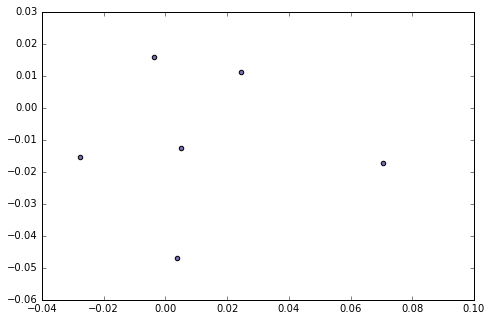

In [55]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#ffff00'}

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

for i in [2]:
    cluster_x = []
    cluster_y = []
    for j in range(len(labels)):
        if labels[j] == i:
            cluster_x.append(cluster_x.append(xs[j]))
            cluster_y.append(cluster_y.append(ys[j]))
    plt.scatter(cluster_x, cluster_y, c=cluster_colors[i], s=20)
    
plt.savefig('cluster_2.png', dpi=200)

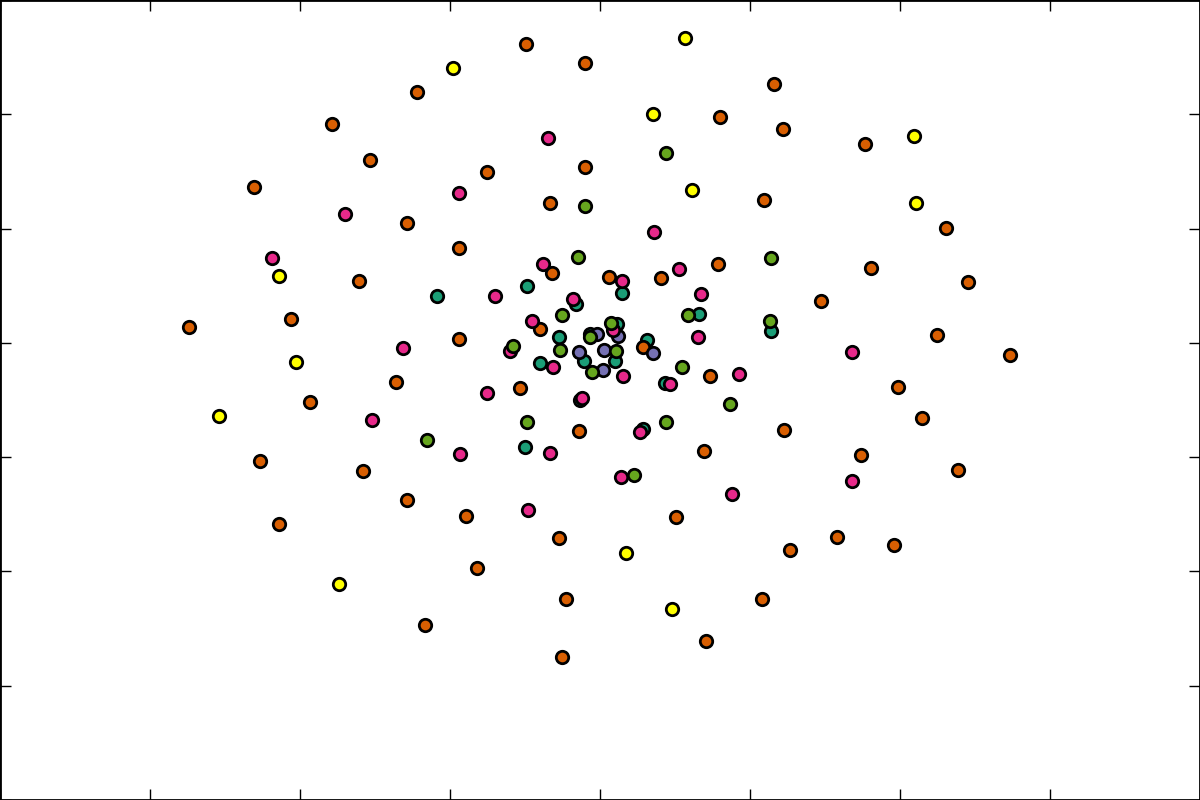

In [50]:
Image("cluster.png")

In [81]:
topics = [2,4,5,5,5,5,4,3,4
,4
,5
,5
,5
,4
,4
,6
,4
,2
,2
,4
,1
,4
,5
,5
,4
,4
,4
,1
,4
,7
,5
,3
,4
,1
,2
,4
,4
,2
,2
,1
,7
,4
,6
,3
,2
,7
,2
,3
,6
,4
,3
,2
,6
,6
,2
,5
,4
,4
,4
,3
,4
,0
,4
,4
,3
,6
,6
,6
,0
,2
,0
,0
,1
,6
,6
,6
,3
,6
,5
,4
,2
,4
,4
,6
,2
,2
,2
,3
,2
,4
,3
,5
,2
,2
,4
,1
,0
,2
,1
,1
,4
,4
,4
,6
,2
,4
,5
,6
,2
,6
,0
,6
,7
,1
,0
,6
,6
,2
,2
,2
,0
,0
,6
,0
,4
,2
,2
,2
,2
,4
,2
,2
,2
,2
,0
,6
,3
,3
,6
,6
,2
,3
,6
,6]

In [84]:
#LDA
lda = LatentDirichletAllocation(n_topics=8, max_iter=100)
y = lda.fit(X,topics)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

print_top_words(lda, vect.get_feature_names(), 20)

Topic #0:
ballet danc new music play perform flamenco york quartet award work choreograph theatr mark compani director opera product year nation
Topic #1:
new jazz music york art work perform school record state hors world year high includ time univers american use group
Topic #2:
christoph book novel macbeth stori live mother read father mrs ed audienc year write world did charact peopl use day
Topic #3:
wang piano deni competit guitar beij russia moscow russian rachmaninoff artist intern studi foundat duo valeri conservatori tchaikovski sergei classic
Topic #4:
opera play glass music perform record new orchestra beach symphoni macbeth work wilson theater theatr audienc role york includ use
Topic #5:
music singer album releas song singl blake record american award love decemb compos septemb year new perform octob juli februari
Topic #6:
play perform shakespear film product theatr new compani festiv jordan art direct adapt work citi comedi text music star set
Topic #7:
orchestra music 

In [86]:
rows = []
for i in range(144):
    topicDist = lda.transform(X[i])
    dist = np.ravel(topicDist)
    dist = [i/sum(dist) for i in dist]
    dist.insert(0,i)
    rows.append(dist)

In [87]:
simDf = df.drop("showId",axis=1)
simMatrix = cosine_similarity(simDf)

In [90]:
#Calculate labels
labels = []
for i in range(144):
    arr = np.ravel(df.iloc[i])[1:]
    if(arr[arr.argmax()] < 0.5):
        labels.append(5)
    else:
        labels.append(arr.argmax())
    
for i in range(8):
    print("cluster ",i)
    mySum = 0
    for j in range(144):
        if(labels[j] == i):
            print(titles[j])
            mySum += 1
    print("sum ",mySum)
    print ("***")

cluster  0
Pavel Haas Quartet
Murray Perahia
Artemis Quartet
Anne-Sophie Mutter,
Andras Schiff
Apollo's Fire
Akademie fur Alte Musik Berlin
Kremerata Baltica
Hagen Quartet
St Lawrence Quartet
Belcea Quartet
Emerson String Quartet
Takacs Quartet
Jerusalem String Quartet
Ariel Quartet
St Lawrence String Quartet
Elias String Quartet
sum  17
***
cluster  1
The Infernal Comedy
Yuja Wang
London Philharmonic
Hamburg Symphony
Chicago Symphony Orchestra
San Francisco Symphony
Mariinsky Orchestra
Detroit Symphony Orchestra
New York Philharmonic
Bobby McFerrin
Alison Balsom
Audra McDonald
St Petersburg Philharmonic
Israel Philharmonic
Olga Kern
Tara Erraught, mezzo
Denis Matsuev
Milhaud's Oresteian
Einstein on the Beach
Chamber Ensemble of the Shanghai Chinese Orchestra
Aspen Santa Fe Ballet
Gilberto Gil
Mariachi Vargas de Tecalitlan
The Silk Road Ensemble
Chris Thile
State Symphony Capella of Russia
New Century Chamber Orchestra: Nadja Salerno-Sonnenberg
Mark Morris Dance Group
Goran Bregovic
Di

In [93]:
topicWords = []
for i in range(8):
    words = ""
    for j in range(len(descs)):
        if topics[j] == i:
            words += descs[j]
    topicWords.append(words)

In [107]:
topicWordsCleaned = [tokenize_and_stem(i) for i in topicWords]
topicWordsCleaned = [[i for i in j if i not in ENGLISH_STOP_WORDS] for j in topicWordsCleaned]

In [111]:
for i in range(8):
    print("topic",i)
    count = Counter()
    for word in topicWordsCleaned[i]:
        count[word] += 1
    print(count.most_common(10))

topic 0
[('jazz', 40), ('lincoln', 20), ('center', 19), ('music', 19), ('orchestra', 15), ('perform', 14), ('new', 11), ('band', 10), ('year', 9), ('york', 8)]
topic 1
[('perform', 19), ('music', 9), ('group', 8), ('singer', 8), ('time', 8), ('program', 7), ('work', 7), ('cultur', 6), ('um', 6), ('choral', 6)]
topic 2
[('theatr', 31), ('nation', 28), ('play', 28), ('london', 22), ('perform', 22), ('product', 21), ('broadcast', 20), ('theater', 17), ('new', 16), ('um', 16)]
topic 3
[('danc', 27), ('ballet', 22), ('compani', 19), ('perform', 17), ('choreograph', 12), ('new', 10), ('work', 10), ('dancer', 10), ('forsyth', 9), ('time', 9)]
topic 4
[('music', 50), ('perform', 41), ('quartet', 38), ('um', 28), ('concert', 24), ('work', 20), ('compos', 20), ('string', 18), ('appear', 18), ('program', 18)]
topic 5
[('orchestra', 16), ('perform', 16), ('symphoni', 16), ('music', 14), ('philharmon', 11), ('concert', 10), ('um', 9), ('work', 9), ('compos', 8), ('wind', 8)]
topic 6
[('music', 71),